## IMPORT RELEVANT LIBRARIES

In [140]:
# DATA EXTRACTION
import glob
import os

# Data Manipulation
import numpy as np
import pandas as pd

# Data Visulization
from missingno import matrix
from skimpy    import skim
import matplotlib.pyplot as plt
import seaborn as sns 

# Data Information 

#### Class information
<img src="data types.jpg">



## DATA EXTRACTION 

- Collect the directories of all files 
- Obtain each data
- Aggregate data by choosen metric 
    - Time range - 5 Minutes
    - Aggregator - Median
- Join all in a data frame using a loop and the pd.concat statement

In [2]:
# Establish root dir wher files resides
# This depends on your PC, Find the directory to the 3W folder
root_dir = r"C:\Users\Owner\Desktop\IT\Group project - W3\3W"

# Get all file Diretiories 
directiories = []
for i in range(0,9):
    directiories.append(root_dir  + f'\\{i}')

# Extract all file names directories 
files = []
for dir_name in directiories:
    files = files + glob.glob(os.path.join(dir_name, "*.csv"))

## DATA WRANGLING
- Data aggregation by hours   and class
- Data aggregation(use median for agg, or use max - min/2 ) by minutes(1, 10) and class


In [3]:
def data_collect(directory, time ,style ):
    '''
    This code aggregates each individual file 
    
    styles include - median, midrange, max, min, mode
    
    '''
    return pd.read_csv(directory, parse_dates= [0]).resample(time, on = 'timestamp').agg(style).reset_index()
    

def joinall(files, time = '10T', style = 'median'):
    '''
    This code block empasizes om joining each aggregated dataframe together
    '''
    
    ct = 0
    
    for dir_ in files:
         
        if ct == 0 :
            df = data_collect(dir_ , time, style)    
        else:
            df = pd.concat([df,data_collect(dir_, time, style)], axis = 0)
            
        ct+= 1
        
    return df.reset_index(drop =True)

In [4]:
df = joinall(files, time = '1T', style = 'median')
df.to_csv('combined_1mins_median.csv', index = False)

## DATA CLEANING 

- check for speling inconsitencies -- There are no string to check for inconsitencies
- check is missing /null data 
- check or duplicates
- check for data types

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850591 entries, 0 to 850590
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  850591 non-null  int64  
 1   timestamp   850591 non-null  object 
 2   P-PDG       850520 non-null  float64
 3   P-TPT       850517 non-null  float64
 4   T-TPT       753558 non-null  float64
 5   P-MON-CKP   831839 non-null  float64
 6   T-JUS-CKP   822128 non-null  float64
 7   P-JUS-CKGL  169005 non-null  float64
 8   T-JUS-CKGL  0 non-null       float64
 9   QGL         180531 non-null  float64
 10  class       850556 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 71.4+ MB


<AxesSubplot:>

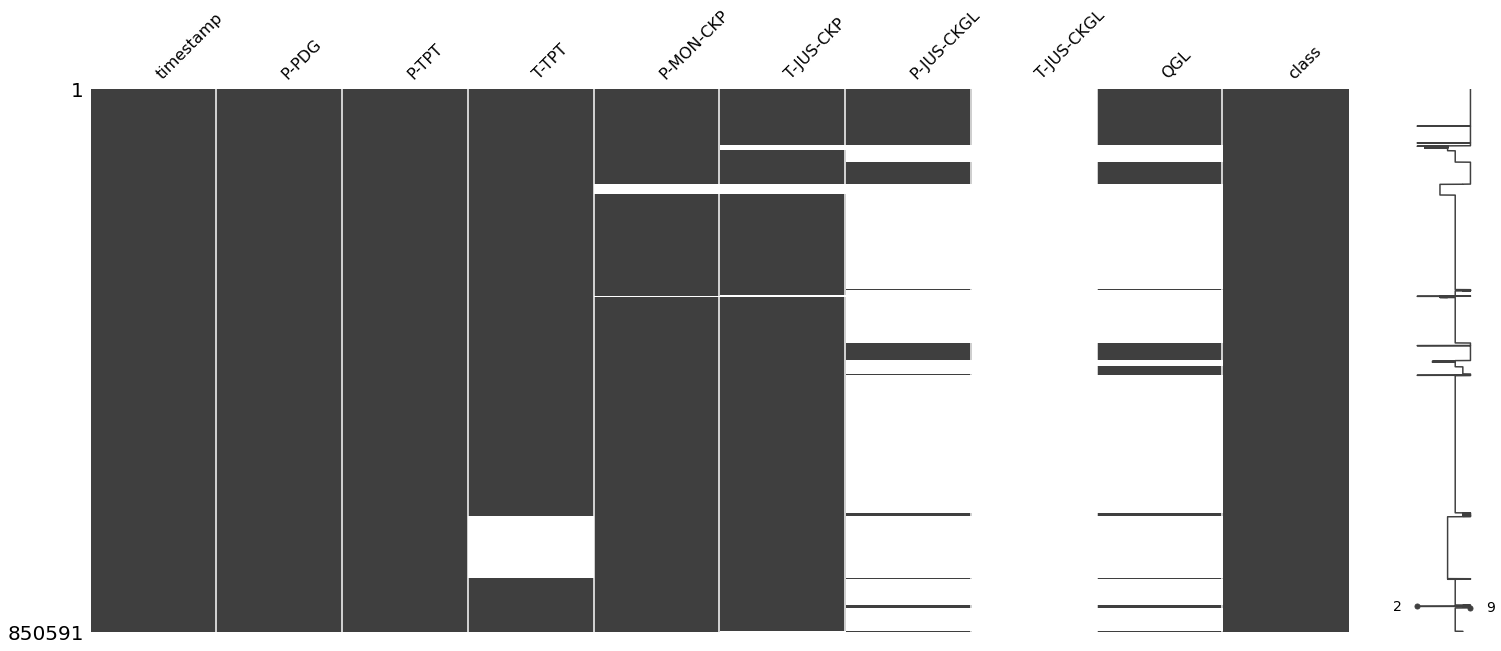

In [6]:
matrix(df)

In [105]:
def per_missing(df):
    '''
    Finds the percentage of missing values in each column
    '''
    tot_len = len(df)
    
    per_missing = df.isna().sum().to_frame()
    per_missing[0] = (per_missing[0]/tot_len) *100
    return per_missing.sort_values(by = [0], ascending= False)

per_missing(df)

,0
T-JUS-CKGL,100.000000
P-JUS-CKGL,80.130874
QGL,78.775816
T-TPT,11.407715
T-JUS-CKP,3.346262
P-MON-CKP,2.204585
P-TPT,0.008700
P-PDG,0.008347
class,0.004115
Unnamed: 0,0.000000


There are 3 Columns with alot of missing data(> 50%)
- P-JUS-CKGL     
- T-JUS-CKGL     
- QGL    
Solution - Drop Columns

Others have just a few(>1% but < 15%>)
- T-TPT    - check if the missing data are from the same class      
    - yes , drop colummns
    - no  , fill with iterative imputer  
- P-MON-CKP      
- T-JUS-CKP  
Solution -  fill missing with Sklearn.iterative_imputer 

Also, the class column has some missing column 
Solution - drop rows with missing class

lets Check the pecentage of missing data in those columns 

In [41]:
# Explore T-TPT columnsdf
missing_T_TPT_class =  df['class'][df['T-TPT'].isna()]
missing_T_TPT_class.value_counts()

6.0      64547
106.0    25862
0.0       6593
4.0          9
3.0          8
53.0         5
107.0        5
56.0         4
Name: class, dtype: int64

In [42]:
# We see that the class 6 - Quick Restriction in PCK has alot of missing data
# Our quick guess is to check the percentage of missing data comes from the class = 6

missing_TPT = (64547 + 25862)/(len(df[df['class'] == 6]) + len(df[df['class'] == 106]))

print(f'{(missing_TPT * 100): 1f}% of TPT values that cointains 6 or 106 are missing')

# This simply implies that ue cannot use the T-TPT column if we want to classify the a condition

 99.637418% of TPT values that cointains 6 or 106 are missing


In [66]:
# Solution For with missing data > 10%
"""
POSSIBLE SOLUTIONS 
- Drop all values that cointain 6 or 106
- Drop the T-TPT column 
"""
df1 = df.drop(columns=['T-JUS-CKGL','P-JUS-CKGL','QGL','T-TPT'], drop)

#### Cleaning Class column

In [58]:
df1['class'].value_counts().sort_index()

0.0      200642
1.0       48495
2.0        6056
3.0       80677
4.0       41477
5.0      176064
6.0       64767
7.0        1812
8.0       10135
50.5          2
51.0          2
52.5          7
53.0          5
54.0          1
55.0          9
56.0          4
101.0     87975
102.0      2446
105.0     40346
106.0     25971
107.0     38365
108.0     25298
Name: class, dtype: int64

In [110]:
# The classes 10 - 100 are errror, so we drop then
df1  = (df1[(df1['class'] < 10) | (df1['class'] > 100)])

In [100]:
#Find null class --- There are no null classes 
print('There are',df['class'].isna().sum(), 'missing values in the class column')
print('which is',(df['class'].isna().sum()/len(df))*100, 'of the entire data')

There are 35 missing values in the class column
which is 0.004114786072272103 of the entire data


In [99]:
#compare the use of foward and backward fill
df2 = df1[['class','timestamp']].copy()
df2['backfill']  = df2['class'].fillna(method='backfill')
df2['ffill']     = df2['class'].fillna(method='pad')

df2.iloc[list(df1[df1['class'].isna()].index), -2:]

,backfill,ffill
314811,1.0,101.0
315151,101.0,0.0
315152,101.0,0.0
315153,101.0,0.0
315154,101.0,0.0
315155,101.0,0.0
315156,101.0,0.0
315805,101.0,0.0
315806,101.0,0.0
316157,1.0,101.0


The nulls, look so much as the transient periods between a normal and a steady state.
Without much certainty of this is, where this chages resides and considering it is a very minute portion os the data set,
it would be best to drop na

In [109]:
df1 = df1[df1['class'].notna()]
per_missing(df1)

,0
T-JUS-CKP,3.346282
P-MON-CKP,2.204676
P-TPT,0.008700
P-PDG,0.008347
timestamp,0.000000
class,0.000000


Postpone fill null values untill after wrangling and data viz

## DATA WRANGLING & FUTHER CLEANING
- CONVERT CLASS TO INTEGERS 
- CONVERT TIMESTAMP TO DATETIME
- CREATE CLASS_TYPE COLUMN
- CREATE FAULT_TYPE COLUMN

In [112]:
# CONVERT CLASS TO INTEGERS
df1['class'] = df1['class'].astype(int)

# CONVERT TIMESTAMP TO DATETIME
df1['timestamp'] = pd.to_datetime(df1['timestamp'])

In [179]:
# CREATE CLASS_TYPE COLUMN
def class_type(x):
    
    if x == 0:
        return 'Normal'
    elif 0 < x < 10:
        return 'Faulty'
    else :
        return 'Transient'
    
df1['Class_type'] = df1['class'].apply(class_type)

In [130]:

faults = {  0:'Normal' ,
            1:'Abrupt Increase of BSW' ,
            2:'Spurious Closure of DHSV' ,
            3:'Severe Slugging' ,
            4:'Flow Instability' ,
            5:'Rapid Productivity Loss' ,
            6:'Quick Restriction  in PCK',
            7:'Scaling in PCK',
            8:'Hydrate in Production Line'}

transient = {101 : 'To Fault 1',  
             102 : 'To Fault 2' , 
             105 : 'To Fault 3',  
             106 : 'To Fault 6',  
             107 : 'To Fault 7',  
             108 : 'To Fault 8',  }

fault_transient  = faults | transient

In [135]:
# CREATE FAULT_TYPE or TRANSIENT TYPE COLUMN
df1['Fault_Type'] = df1['class'].map(fault_transient)

## EXPLORATORY DATA ANALYSIS and  more Data Cleaning 
- Use skim to summeraize data
- Find Correlation using heatmap
- outlier detection - Boxplots 
- Scatterplots and violinplots for trends 
- Consider if ther is are trends with time 
- 
- Use pairplot to find trends
- 
-


<AxesSubplot:>

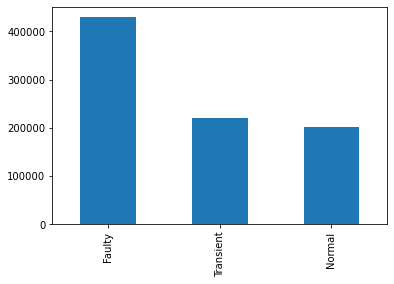

In [180]:
df1['Class_type'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

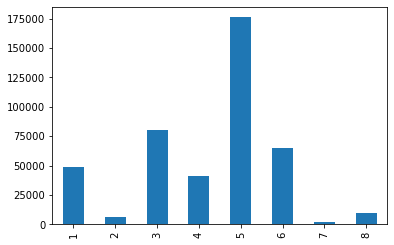

In [185]:
df1['class'][df1['Class_type'] == 'Faulty'].value_counts().sort_index().plot(kind = 'bar')

<AxesSubplot:>

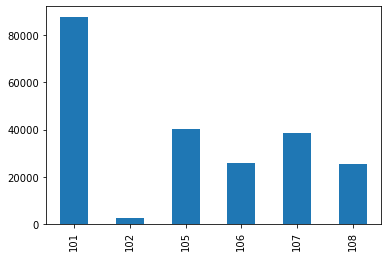

In [187]:
df1['class'][df1['Class_type'] == 'Transient'].value_counts().sort_index().plot(kind = 'bar')

In [ ]:
skim(df1)

╭───────────────────────────────────── skimpy summary ──────────────────────────────────────╮
│          Data Summary                Data Types                                           │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                    │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                    │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                    │
│ │ Number of rows    │ 850526 │ │ float64     │ 4     │                                    │
│ │ Number of columns │ 8      │ │ object      │ 2     │                                    │
│ └───────────────────┴────────┘ │ datetime64  │ 1     │                                    │
│                                │ int32       │ 1     │                                    │
│                                └─────────────┴───────┘                                    │
│                                          number                                           │
│ ┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┓  │
│ ┃        ┃ missin ┃ comple ┃ mean   ┃ sd     ┃ p0    ┃ p25    ┃ p75   ┃ p100   ┃ hist  ┃  │
│ ┃        ┃ g      ┃ te     ┃        ┃        ┃       ┃        ┃       ┃        ┃       ┃  │
│ ┃        ┃        ┃ rate   ┃        ┃        ┃       ┃        ┃       ┃        ┃       ┃  │
│ ┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━┩  │
│ │ P-PDG  │     71 │      1 │ -4.9e+ │ 7.6e+4 │ -1.2e │ 120000 │ 26000 │ 310000 │       │  │
│ │        │        │        │     39 │        │   +42 │     00 │   000 │   0000 │   █   │  │
│ │ P-TPT  │     74 │      1 │ 160000 │ 600000 │     0 │ 110000 │ 18000 │ 290000 │   █   │  │
│ │        │        │        │     00 │     00 │       │     00 │   000 │   0000 │       │  │
│ │ P-MON- │  19000 │   0.98 │ 360000 │ 340000 │ -8300 │ 120000 │ 51000 │ 130000 │ █▃▁▁▁ │  │
│ │ CKP    │        │        │      0 │      0 │       │      0 │    00 │     00 │   ▁   │  │
│ │ T-JUS- │  28000 │   0.97 │     76 │     22 │  -1.7 │     67 │    85 │    170 │  ▂█▃  │  │
│ │ CKP    │        │        │        │        │       │        │       │        │       │  │
│ │ class  │      0 │      1 │     29 │     44 │     0 │      1 │   100 │    110 │   █   │  │
│ │        │        │        │        │        │       │        │       │        │   ▃   │  │
│ └────────┴────────┴────────┴────────┴────────┴───────┴────────┴───────┴────────┴───────┘  │
│                                         datetime                                          │
│ ┏━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃           ┃ missing ┃ complete rate ┃ first           ┃ last             ┃ frequency ┃  │
│ ┡━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ timestamp │       0 │             1 │   2012-04-10    │    2018-10-07    │ None      │  │
│ │           │         │               │    19:23:00     │     21:12:00     │           │  │
│ └───────────┴─────────┴───────────────┴─────────────────┴──────────────────┴───────────┘  │
╰─────────────────────────────────────────── End ───────────────────────────────────────────╯

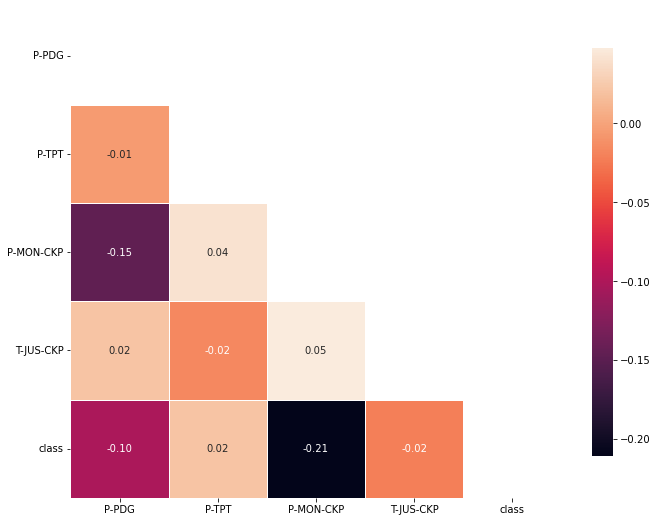

In [153]:
##create correlation table 
df_corr = df1.corr()

##create mask to remove upper boundaries 
mask = np.zeros_like(df_corr, dtype = bool)
mask[np.triu_indices_from(mask)]= True

##plot heatmap
f, ax = plt.subplots(figsize=(11, 15))
sns.heatmap(df_corr, annot=True, fmt='.2f', mask=mask, 
              square=True, linewidths=.5, cbar_kws={"shrink": .5})
#add the column names as labels
ax.set_yticklabels(df_corr.columns, rotation = 0)
ax.set_xticklabels(df_corr.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

<AxesSubplot:xlabel='Class_type', ylabel='T-JUS-CKP'>

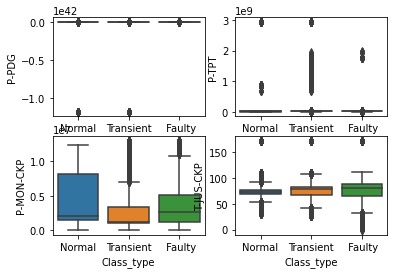

In [169]:


#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2)

#create boxplot in each subplot
sns.boxplot(data = df1 , y = 'P-PDG',    x = 'Class_type',  ax=axes[0,0])
sns.boxplot(data = df1 , y = 'P-TPT',    x = 'Class_type',  ax=axes[0,1])
sns.boxplot(data = df1 , y = 'P-MON-CKP',x = 'Class_type',  ax=axes[1,0])
sns.boxplot(data = df1 , y = 'T-JUS-CKP',x = 'Class_type',  ax=axes[1,1])

In [197]:
def class_distribution(param):
    
    return df1[[param, 'Class_type']].groupby('Class_type').quantile(np.linspace(0,0.01,11)).unstack()


flt_var = ['P-PDG', 'P-TPT', 'P-MON-CKP' , 'T-JUS-CKP']

class_distribution(flt_var[0])

P-PDG                                            \
                   0.000         0.001         0.002         0.003   
Class_type                                                           
Faulty      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
Normal     -1.180116e+42 -1.180116e+42 -6.887865e+06 -6.887865e+06   
Transient  -1.180116e+42 -1.180116e+42 -1.180116e+42 -1.180116e+42   

                                                                    \
                   0.004         0.005         0.006         0.007   
Class_type                                                           
Faulty      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
Normal     -6.887865e+06 -6.887865e+06 -6.887865e+06 -6.887865e+06   
Transient  -1.180116e+42 -1.180116e+42 -1.180116e+42 -1.180116e+42   

                                                      
                   0.008         0.009         0.010  
Class_type                                            
Faulty      0.000000e+00  0.000000e+00  0.000000e+00  
Normal     -6.887865e+06 -6.887865e+06 -6.887865e+06  
Transient  -1.180116e+42 -1.180116e+42 -1.180116e+42

In [198]:
df1[df1['P-PDG'] < 0]

,timestamp,P-PDG,P-TPT,P-MON-CKP,T-JUS-CKP,class,Class_type,Fault_Type
20142,2017-06-27 00:55:00,-2.977046e+07,14187530.0,6017048.0,69.781355,0,Normal,Normal
20143,2017-06-27 00:56:00,-6.285372e+07,14197420.0,6046614.5,69.488450,0,Normal,Normal
20144,2017-06-27 00:57:00,-9.593698e+07,14207310.0,6062451.0,69.724230,0,Normal,Normal
20145,2017-06-27 00:58:00,-1.193710e+08,14214320.0,6056848.0,69.775490,0,Normal,Normal
20146,2017-06-27 01:03:00,-6.887865e+06,14244000.0,6021893.0,69.582760,0,Normal,Normal
...,...,...,...,...,...,...,...,...
811998,2018-06-21 13:21:00,-1.180116e+42,21237915.0,12294625.0,64.730185,107,Transient,To Fault 7
811999,2018-06-21 13:22:00,-1.180116e+42,21231745.0,12294025.0,64.729645,107,Transient,To Fault 7
812000,2018-06-21 13:23:00,-1.180116e+42,21228840.0,12290945.0,64.729115,107,Transient,To Fault 7
812001,2018-06-21 13:24:00,-1.180116e+42,21241690.0,12292750.0,64.728580,107,Transient,To Fault 7


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute       import IterativeImputer

## FEATURE EXTRACTION 
- 

## MODEL CREATION
- 